In [136]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import os
import cv2

In [137]:
def label(img_desc):
    return [1,0] if file['meta']['clinical']['benign_malignant']=='benign' else [0,1]

In [138]:
def relabel(arr):
    if arr[1]==0 and arr[0]==1:
        return 'benign'
    elif arr[0]==0 and arr[1]==1:
        return 'malignant'

In [143]:
data=[]

#load data
for path in [['benign/*.jpeg', 'b_desc/'],['malignant/*.jpeg', 'm_desc/']]:
    for filepath in glob.iglob(path[0]):
        sample=filepath.split('/')[-1].split('.jpeg')[0]
        img=cv2.resize(cv2.imread(filepath,cv2.IMREAD_GRAYSCALE), (50,50))
        with open(path[1]+sample) as json_file:
            file=json.load(json_file)
        data.append([np.array(img),np.array(label(file))])

shuffle(data)
data=np.array(data, dtype=object)
# train_data=np.array(data[:7000],dtype=object)
# test_data=np.array(data[7000:],dtype=object)

#k batch testing
dataset=np.array_split(data,10)

In [144]:
# np.save('train_data.npy', train_data)
# np.save('test_data.npy',test_data)

np.save('batch_dataset.npy',dataset)

In [175]:
tf.compat.v1.reset_default_graph()
convnet = input_data(shape =[None, 50, 50, 1], name ='input')
 
convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 128, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = fully_connected(convnet, 1024, activation ='relu')
convnet = dropout(convnet, 0.8)
 
convnet = fully_connected(convnet, 2, activation ='softmax')
convnet = regression(convnet, optimizer ='adam', learning_rate = 1e-3,
      loss ='categorical_crossentropy', name ='targets')
 
model = tflearn.DNN(convnet, tensorboard_dir ='log')

# Test-train split

In [174]:
train_data = np.load('train_data.npy', allow_pickle=True)
test_data = np.load('test_data.npy', allow_pickle=True)

In [176]:
X = np.array([i[0] for i in train_data]).reshape(-1, 50, 50, 1)
Y = [i[1] for i in train_data]
test_x = np.array([i[0] for i in test_data]).reshape(-1, 50, 50, 1)
test_y = [i[1] for i in dataset[exclude]]

# epoch = 5 taken
model.fit({'input': X}, {'targets': Y}, n_epoch = 10,
    validation_set =({'input': test_x}, {'targets': test_y}),
    snapshot_step = 500, show_metric = True)

Training Step: 1099  | total loss: 0.17927 | time: 7.608s
| Adam | epoch: 010 | loss: 0.17927 - acc: 0.9395 -- iter: 6976/7000


Exception in thread Thread-759:
Traceback (most recent call last):
  File "/Users/emilygan/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/emilygan/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/emilygan/opt/anaconda3/lib/python3.8/site-packages/tflearn/data_flow.py", line 187, in fill_feed_dict_queue
    data = self.retrieve_data(batch_ids)
  File "/Users/emilygan/opt/anaconda3/lib/python3.8/site-packages/tflearn/data_flow.py", line 222, in retrieve_data
    utils.slice_array(self.feed_dict[key], batch_ids)
  File "/Users/emilygan/opt/anaconda3/lib/python3.8/site-packages/tflearn/utils.py", line 204, in slice_array
    return X[start]
IndexError: index 999 is out of bounds for axis 0 with size 999


Training Step: 1100  | total loss: 0.18174 | time: 8.688s
| Adam | epoch: 010 | loss: 0.18174 - acc: 0.9378 | val_loss: 0.86015 - val_acc: 0.1585 -- iter: 7000/7000
--


<AxesSubplot:>

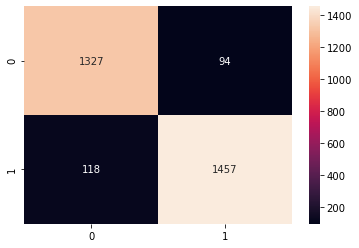

In [177]:
predictions=[relabel(np.rint(list(model.predict([i[0].reshape(50, 50, 1)])))[0]) for i in test_data]
labels=[relabel(i[1]) for i in test_data]
tp=0
tn=0
fp=0
fn=0
for i,j in zip(labels,predictions):
    if i==j=='benign':
        tp+=1
    elif i==j=='malignant':
        tn+=1
    elif i=='benign':
        fn+=1
    elif i=='malignant':
        fp+=1
df=pd.DataFrame([[tp/,fp],[fn,tn]])
sns.heatmap(df, annot=True, fmt='')

# Batch training

In [180]:
dataset = np.load('batch_dataset.npy', allow_pickle=True)
train_data=[i for j in range(9) for i in dataset[j]]
test_data=[i for i in dataset[9]]

In [181]:
for exclude in range(9):
    X = np.array([i[0] for j in range(9) if j!=exclude for i in dataset[j]]).reshape(-1, 50, 50, 1)
    Y = [i[1] for j in range(9) if j!=exclude for i in dataset[j]]
    test_x = np.array([i[0] for i in dataset[exclude]]).reshape(-1, 50, 50, 1)
    test_y = [i[1] for i in dataset[exclude]]

    # epoch = 5 taken
    model.fit({'input': X}, {'targets': Y}, n_epoch = 10,
        validation_set =({'input': test_x}, {'targets': test_y}),
        snapshot_step = 500, show_metric = True)

X = np.array([i[0] for i in train_data]).reshape(-1, 50, 50, 1)
Y = [i[1] for i in train_data]
test_x = np.array([i[0] for i in test_data]).reshape(-1, 50, 50, 1)
test_y = [i[1] for i in dataset[exclude]]

# epoch = 5 taken
model.fit({'input': X}, {'targets': Y}, n_epoch = 10,
    validation_set =({'input': test_x}, {'targets': test_y}),
    snapshot_step = 500, show_metric = True)

Training Step: 13759  | total loss: 0.07908 | time: 8.481s
| Adam | epoch: 110 | loss: 0.07908 - acc: 0.9898 -- iter: 8960/8997
Training Step: 13760  | total loss: 0.07321 | time: 9.546s
| Adam | epoch: 110 | loss: 0.07321 - acc: 0.9909 | val_loss: 3.99297 - val_acc: 0.4785 -- iter: 8997/8997
--


<AxesSubplot:>

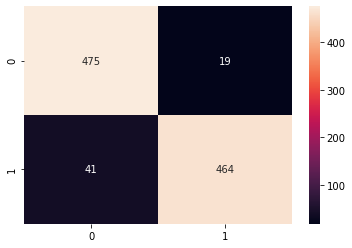

In [184]:
predictions=[relabel(np.rint(list(model.predict([i[0].reshape(50, 50, 1)])))[0]) for i in test_data]
labels=[relabel(i[1]) for i in test_data]
tp=0
tn=0
fp=0
fn=0
for i,j in zip(labels,predictions):
    if i==j=='benign':
        tp+=1
    elif i==j=='malignant':
        tn+=1
    elif i=='benign':
        fn+=1
    elif i=='malignant':
        fp+=1

df=pd.DataFrame([[tp,fp],[fn,tn]])
sns.heatmap(df, annot=True, fmt='')

In [173]:
#check some predictions
fig=plt.figure()
for num, data in enumerate(dataset[0][:20]):
    # benign: [1, 0]
    # malignant: [0, 1]
    
    img_label = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 5, num + 1)
    orig = img_data
    data = img_data.reshape(50, 50, 1)
 
    # model_out = model.predict([data])[0]
    model_out = model.predict([img_data])
     
    if np.argmax(model_out) == 1: str_label ='Benign'
    else: str_label='Malignant'
    
    y.imshow(orig, cmap ='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.tight_layout()

IndentationError: unexpected indent (<ipython-input-173-441f37f798c4>, line 19)